In [1]:
!pip install -q timm

In [ ]:
# Suppress pydantic warnings
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="pydantic")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchaudio
import timm  # PyTorch Image Models (for EfficientNet)
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split


# --- CONFIGURATION (Based on 1st Place Solution) ---
class Config:
    SR = 32000  # Sample Rate (32kHz is standard for BirdCLEF)
    N_MELS = 128  # Number of Mel bands (Height of image)
    FMIN = 20  # Min frequency
    FMAX = 16000  # Max frequency (Nyquist frequency of 32k)
    DURATION = 5  # Duration of audio chunks in seconds
    BATCH_SIZE = 32
    EPOCHS = 3  # Keep it small for the baseline
    MODEL_NAME = "efficientnet_b0"  # Lightweight baseline model
    NUM_CLASSES = 206  # Total species in BirdCLEF 2025 (check metadata!)

    # Paths (Correct paths for Kaggle)
    TRAIN_AUDIO_DIR = "/kaggle/input/birdclef-2025/train_audio"
    TRAIN_METADATA = "/kaggle/input/birdclef-2025/train.csv"


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {DEVICE}")

Using Device: cuda


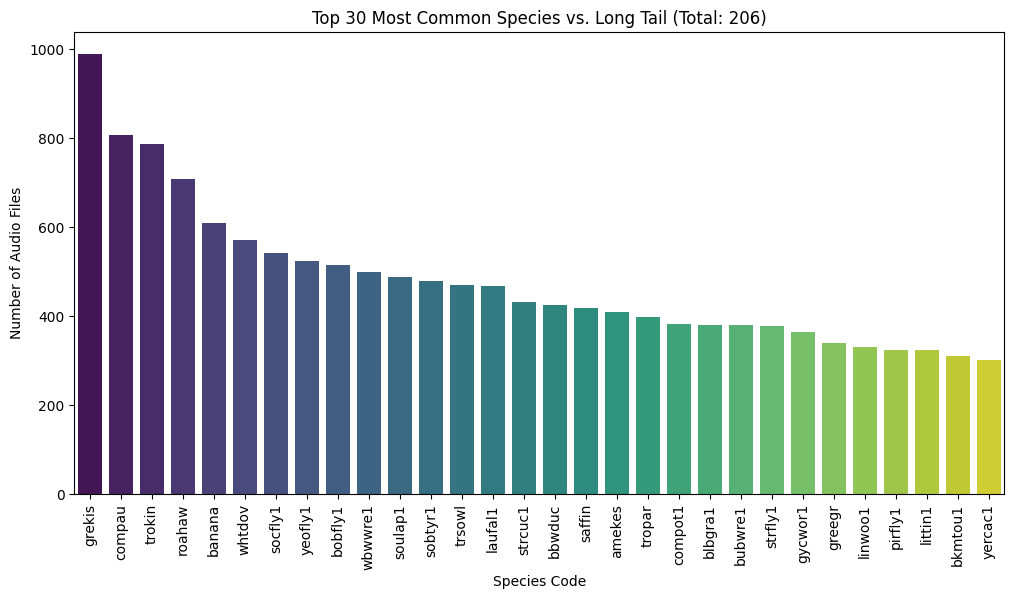

Rarest 5 Species: primary_label
42113      2
21116      2
1139490    2
21038      2
64862      2
Name: count, dtype: int64


In [10]:
# Load Metadata
df = pd.read_csv(Config.TRAIN_METADATA)

# Count samples per species
species_counts = df["primary_label"].value_counts().sort_values(ascending=False)

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(
    x=species_counts.index[:30],
    y=species_counts.values[:30],
    hue=species_counts.index[:30],
    palette="viridis",
    legend=False,
)
plt.xticks(rotation=90)
plt.title(f"Top 30 Most Common Species vs. Long Tail (Total: {len(species_counts)})")
plt.ylabel("Number of Audio Files")
plt.xlabel("Species Code")
plt.show()

# Check the "Long Tail" (Rare species)
print("Rarest 5 Species:", species_counts.tail(5))

In [ ]:
# Generate and Save All Spectrograms
import cv2
from pathlib import Path

# Create output directory
OUTPUT_DIR = "/kaggle/working/spectrograms"
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

print(f"Generating spectrograms for {len(df)} audio files...")
print(f"Saving to: {OUTPUT_DIR}")

# Process each audio file
for idx in tqdm(range(len(df)), desc="Processing audio files"):
    row = df.iloc[idx]
    species = row["primary_label"]
    filename = row["filename"]

    # Create species directory
    species_dir = Path(OUTPUT_DIR) / species
    species_dir.mkdir(parents=True, exist_ok=True)

    try:
        # Load and process audio
        file_path = os.path.join(Config.TRAIN_AUDIO_DIR, filename)
        waveform, sr = torchaudio.load(file_path)

        # Resample if necessary
        if sr != Config.SR:
            resampler = torchaudio.transforms.Resample(sr, Config.SR)
            waveform = resampler(waveform)

        # Crop/Pad to 5 seconds
        target_len = Config.SR * Config.DURATION
        current_len = waveform.shape[1]

        if current_len > target_len:
            # Take from the start for consistency
            waveform = waveform[:, :target_len]
        else:
            padding = target_len - current_len
            waveform = torch.nn.functional.pad(waveform, (0, padding))

        # Convert to MelSpectrogram
        mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=Config.SR,
            n_mels=Config.N_MELS,
            f_min=Config.FMIN,
            f_max=Config.FMAX,
        )
        mel_spec = mel_transform(waveform)

        # Convert to dB scale
        mel_spec = torchaudio.transforms.AmplitudeToDB()(mel_spec)

        # Convert to numpy and normalize to 0-255 range for image saving
        mel_spec_np = mel_spec[0].numpy()  # Take first channel
        mel_spec_np = (
            (mel_spec_np - mel_spec_np.min())
            / (mel_spec_np.max() - mel_spec_np.min())
            * 255
        ).astype(np.uint8)

        # Save as image
        output_filename = Path(filename).stem + ".png"
        output_path = species_dir / output_filename
        cv2.imwrite(str(output_path), mel_spec_np)

    except Exception as e:
        print(f"Error processing {filename}: {e}")
        continue

print(f"\n✓ Spectrograms saved to {OUTPUT_DIR}")
print(f"✓ Organized by species in subdirectories")
print(f"✓ Total species folders: {len(list(Path(OUTPUT_DIR).iterdir()))}")

/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

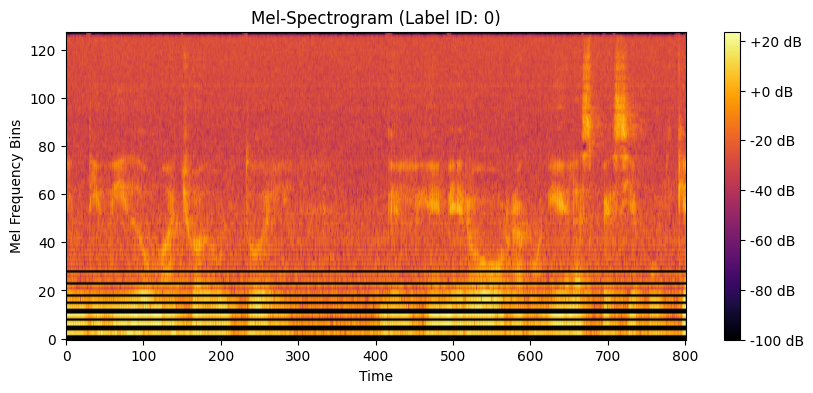

In [ ]:
class BirdCLEFDataset(Dataset):
    def __init__(self, metadata, audio_dir, transform=None):
        self.metadata = metadata
        self.audio_dir = audio_dir
        self.species_to_idx = {
            species: idx
            for idx, species in enumerate(sorted(metadata["primary_label"].unique()))
        }

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        file_path = os.path.join(self.audio_dir, row["filename"])

        # 1. Load Audio
        # Torchaudio loads as (channels, samples). We only want 1 channel.
        waveform, sr = torchaudio.load(file_path)

        # Resample if necessary (though most are already 32k)
        if sr != Config.SR:
            resampler = torchaudio.transforms.Resample(sr, Config.SR)
            waveform = resampler(waveform)

        # 2. Crop/Pad to Specific Duration (5 Seconds)
        target_len = Config.SR * Config.DURATION
        current_len = waveform.shape[1]

        if current_len > target_len:
            # Random crop
            start = torch.randint(0, current_len - target_len, (1,)).item()
            waveform = waveform[:, start : start + target_len]
        else:
            # Pad with zeros
            padding = target_len - current_len
            waveform = torch.nn.functional.pad(waveform, (0, padding))

        # 3. Convert to MelSpectrogram
        mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=Config.SR,
            n_mels=Config.N_MELS,
            f_min=Config.FMIN,
            f_max=Config.FMAX,
        )
        mel_spec = mel_transform(waveform)

        # 4. Convert to Log Scale (Amplitude to Decibels)
        # This makes faint sounds more visible to the model
        mel_spec = torchaudio.transforms.AmplitudeToDB()(mel_spec)

        # 5. Create 3 Channels (So it looks like an RGB image for EfficientNet)
        image = mel_spec.repeat(3, 1, 1)  # Shape: [3, 128, 313]

        # Get Label
        label = self.species_to_idx[row["primary_label"]]

        return image, label


# --- Test the Pipeline ---
# Let's visualize one sample to ensure it works
dataset = BirdCLEFDataset(df, Config.TRAIN_AUDIO_DIR)
sample_img, sample_label = dataset[0]

plt.figure(figsize=(10, 4))
# Display only the first channel
plt.imshow(sample_img[0].numpy(), cmap="inferno", aspect="auto", origin="lower")
plt.title(f"Mel-Spectrogram (Label ID: {sample_label})")
plt.ylabel("Mel Frequency Bins")
plt.xlabel("Time")
plt.colorbar(format="%+2.0f dB")
plt.show()

In [ ]:
# 1. Prepare Data Loaders
train_df, val_df = train_test_split(
    df, test_size=0.2, stratify=df["primary_label"], random_state=42
)

train_ds = BirdCLEFDataset(train_df, Config.TRAIN_AUDIO_DIR)
val_ds = BirdCLEFDataset(val_df, Config.TRAIN_AUDIO_DIR)

train_loader = DataLoader(
    train_ds, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=2
)
val_loader = DataLoader(
    val_ds, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=2
)


# 2. Define Model (EfficientNet-B0)
class BirdClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Load pretrained EfficientNet
        self.backbone = timm.create_model(
            Config.MODEL_NAME, pretrained=True, num_classes=num_classes
        )

    def forward(self, x):
        return self.backbone(x)


model = BirdClassifier(num_classes=len(df["primary_label"].unique())).to(DEVICE)

# 3. Training Setup
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 4. Simple Training Loop (Baseline)
print("Starting Baseline Training...")

for epoch in range(Config.EPOCHS):
    model.train()
    train_loss = 0

    # Progress bar for training
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{Config.EPOCHS}")
    for images, labels in pbar:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        pbar.set_postfix({"loss": loss.item()})

    print(f"Epoch {epoch+1} finished. Avg Loss: {train_loss / len(train_loader):.4f}")

    # (Optional: Add Validation loop here to check accuracy)

print("Baseline Training Complete. Save this model as 'baseline_model.pth'")
torch.save(model.state_dict(), "baseline_model.pth")

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Starting Baseline Training...


Epoch 1/3:   0%|          | 0/715 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable

Epoch 1 finished. Avg Loss: 2.7795


Epoch 2/3:   0%|          | 0/715 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/au

Epoch 2 finished. Avg Loss: 1.8918


Epoch 3/3:   0%|          | 0/715 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/au

Epoch 3 finished. Avg Loss: 1.6189
Baseline Training Complete. Save this model as 'baseline_model.pth'
